# CLV-Calculation in Non-Contractual Business

The goal of this notebook is to explore (part) of the functionality of the [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package. The pre-cleaned data is transformed, split into calibration and holdout sets and CLV is then calculated in two steps:
1. Prediction of future purchases with BG/NBD model
2. Prediction of monetary value of these future purchases with Gamma-Gamma model.

Because the results were not so good (maybe partly due to the seasonality in the underlying data, see notebook 1) a second run was made with outliers removed. But this worsened the results.

#### Data Source
- `data/interim/clv_data.csv`: Cleaned data, prepared in first notebook.

#### Data Output
- `models/bgf_model.pkl`: Fitted BG/NBD model (will be re-used in nb 3).

#### Changes
- 19-02-12: Start notebook
- 19-02-15: Calculate CLVs
- 19-02-17: add 2nd run with outliers removed

---

### Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
from lifetimes import BetaGeoFitter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')
%matplotlib inline  

# Special settings for lifetime plots
sns.set_palette("viridis")
sns.set(rc={'image.cmap': 'viridis'})

import cleaning_functions as clean
import EDA_functions as EDA

# Display Settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Load data
clv_data = pd.read_csv('data/interim/clv_data.csv', parse_dates=['InvoiceDate'],
                       dtype={'CustomerID' : str, 'Country' : 'category'})

## 1) Prepare Data


In [3]:
clv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 6 columns):
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null object
Country        397884 non-null category
Sales          397884 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 15.6+ MB


**Note:** For Lifetimes we need an Input Dataframe of transaction data of the form: 
- customer_id
- datetime 
- [monetary_value] (optional, but needed for clv estimations)

### Clean & Transform Data - with holdout set

(see notebook 'basic_functionalities' for transformation without holdout set - Note for a real-life project we would have to remove customers who joined only right before the calibration deadline as those had no chance to make sufficient repeat purchases. See also BG-BB paper, p. 9 for model fitting.)

In [4]:
"""Transform data to 'Lifetimes' format"""

clv_data.drop(['Quantity', 'UnitPrice', 'Country'], inplace=True, axis=1)
clv_data['InvoiceDate'] = clv_data['InvoiceDate'].dt.date

# Use transformation function from liftimes package
clv_cal_holdout = calibration_and_holdout_data(clv_data, 'CustomerID', 'InvoiceDate', 
                                                   monetary_value_col='Sales',
                                                   calibration_period_end='2011-07-09',  # 7 months
                                                   observation_period_end='2011-12-09',  # 5 months
                                                   ) 

**IMPORTANT NOTE:** I tried to fit with a longer cal_period / shorter holdout_period, the fit was poorer than with this configuration. It seems important to experiment with the duration and then assess the fit (see lineplot below).

In [5]:
# Check results
print(clv_cal_holdout.shape)
clv_cal_holdout.head()

(3010, 7)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,172.0,0.000000,0.0,0.000000,<153 * Days>
12347,3.0,184.0,214.0,498.053333,3.0,26.300625,<153 * Days>
12348,2.0,110.0,205.0,297.220000,1.0,103.333333,<153 * Days>
12350,0.0,0.0,157.0,0.000000,0.0,0.000000,<153 * Days>
12352,3.0,34.0,143.0,421.770000,3.0,20.090000,<153 * Days>


**Nomenclature for the CLV model:**

- _Frequency_: represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. (Thus if they have made only 1 purchase, the recency is 0.)
- _T_: represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- _Recency_: represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

**Note:** Only 2800 customers are in the fitting set, because the others made their first order only in the holdout period. (I checked that with help of the original 'customers_data'.)

In [6]:
# 'Repair' duration_holdout: set to float - should not happen according to docs ...
import re
clv_cal_holdout['duration_holdout'] = \
    clv_cal_holdout['duration_holdout'].astype(str)    
clv_cal_holdout['duration_holdout'] = \
    clv_cal_holdout['duration_holdout'].apply(lambda x: int(re.findall('\d+', x)[0]))

In [7]:
# Check results
display(clv_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,172.0,0.000000,0.0,0.000000,153
12347,3.0,184.0,214.0,498.053333,3.0,26.300625,153
12348,2.0,110.0,205.0,297.220000,1.0,103.333333,153
12350,0.0,0.0,157.0,0.000000,0.0,0.000000,153
12352,3.0,34.0,143.0,421.770000,3.0,20.090000,153


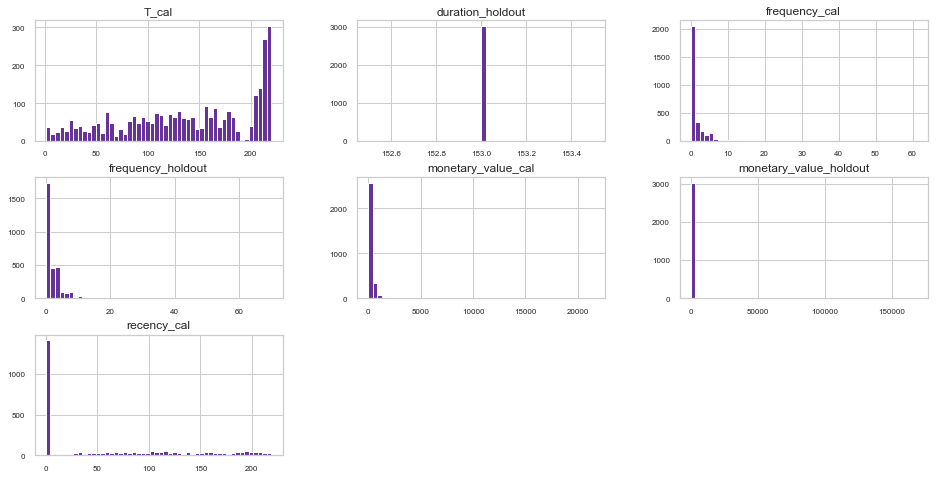

In [8]:
# Check distributions
EDA.plot_num_hist(clv_cal_holdout, figsize=(16,8))

In [9]:
print("prop of customers without repeat purchase in cal_period: ", \
        round(clv_cal_holdout['frequency_cal'].value_counts()[0] / len(clv_cal_holdout),3))

prop of customers without repeat purchase in cal_period:  0.463


**Note:** 46.3% of customers are 'one-timers' in the cal_period. this could well be a problem for fitting the model.

## 2) Forecast number of future purchases with BG / NBD model
The BG /NBD model allows us to compute the expected number of purchases in a forecast period at the customer level. 

class BetaGeoFitter(). This model has the following assumptions:
1. Each individual, `i`, has a hidden `lambda_i` and `p_i` parameter
2. These come from a population wide Gamma and a Beta distribution respectively.
3. Individuals purchases follow a Poisson process with rate `lambda_i*t` .
4. After each purchase, an individual has a p_i probability of dieing (never buying again).

In [10]:
# Fit on the _cal columns, and test on the _holdout columns"""
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv_cal_holdout['frequency_cal'], 
        clv_cal_holdout['recency_cal'], 
        clv_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 3010 subjects, a: 0.00, alpha: 64.78, b: 11.64, r: 0.75>

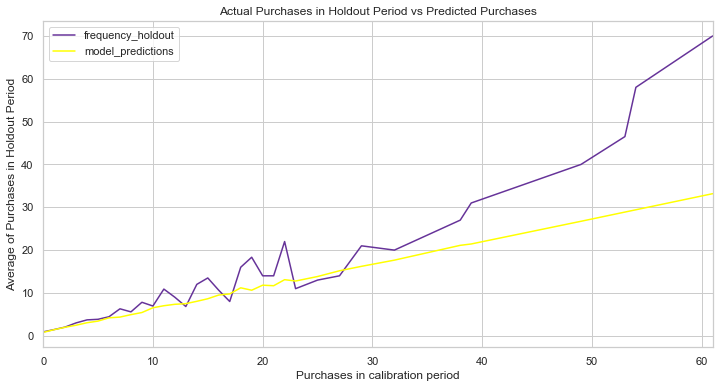

In [11]:
# Plot results
plot_calibration_purchases_vs_holdout_purchases(bgf, 
                                                clv_cal_holdout, 
                                                figsize=(12,6),
                                                n=int(clv_cal_holdout['frequency_cal'].max() + 1),
                                                color=['rebeccapurple', 'yellow']);

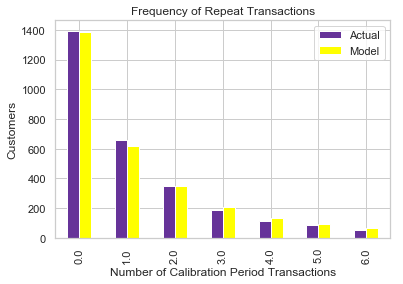

In [12]:
# Assess model fit (with simulated data, cal_period only)
plot_period_transactions(bgf, color=['rebeccapurple', 'yellow']);

In [13]:
# Save model for re-use in nb 3
bgf.save_model('models/bgf_model.pkl', save_data=True, save_generate_data_method=False)
print('model saved')

model saved


### Calculate and Evaluate Individual Customer Predictions
Based on customer history, we can predict how many future purchases an individual might make in a given period.

In [14]:
# Prepare dataset for all customers to predict on
clv = summary_data_from_transaction_data(clv_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales')
# check results
print(clv.shape)
clv.head()

(4338, 4)


,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


In [15]:
def predict_individual_purchases(model, df, t):
    """Predict number of purchases for period t for each customer
    and return them, rounded to int, in a DataFrame.
    """
    pred_list = []
    for customer in df.itertuples():
        pred_purchases = model.predict(t, 
                                     int(customer[1]), 
                                     int(customer[2]), 
                                     int(customer[3])
                                     )
        pred_list.append({'id': customer[0], 
                          'pred_purchases': int(pred_purchases)})  # round to int

    pred_df = pd.DataFrame(pred_list, columns=['id', 'pred_purchases'])
    pred_df.set_index('id', inplace=True)
    
    return pred_df

In [16]:
# Call function and check results
t = clv_cal_holdout.iloc[0,-1]  # set no of periods == duration_holdout
pred_purchases = predict_individual_purchases(bgf, clv, t)
display(pred_purchases.head())

,pred_purchases
id,
12346,0
12347,2
12348,1
12349,1
12350,0


In [17]:
# Compare predictions to effective frequencies in holdout set
pred_evaluation = pd.concat([pred_purchases, 
                             clv_cal_holdout[['frequency_holdout']]], 
                            axis=1, 
                            sort=True
                            )

# For eval only look at customers with frequency value in holdout
pred_evaluation.dropna(how = 'any', inplace=True)
assert len(pred_evaluation) == len(clv_cal_holdout)

print("Pearson's R: ", round(pred_evaluation.corr().iloc[0,1],3))

Pearson's R:  0.958


In [18]:
# Calculate difference of prediction to actual values
pred_evaluation['diff'] = np.abs(pred_evaluation['pred_purchases'] - pred_evaluation['frequency_holdout'])
print("Mean diff: ", pred_evaluation['diff'].sum() / len(pred_evaluation))

Mean diff:  0.8003322259136213


0.0     0.486047
1.0     0.352159
2.0     0.103322
3.0     0.031561
4.0     0.014286
5.0     0.005980
7.0     0.002326
6.0     0.001993
8.0     0.000997
19.0    0.000664
9.0     0.000332
24.0    0.000332
Name: diff, dtype: float64

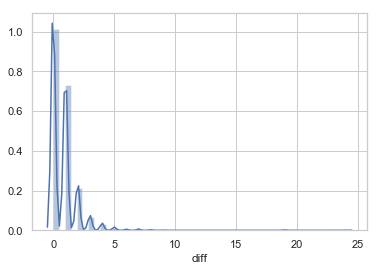

In [19]:
# Display percentage of customers with respective difference ('error')
display(pred_evaluation['diff'].value_counts(dropna=False) / len(pred_evaluation))
sns.distplot(pred_evaluation['diff']);

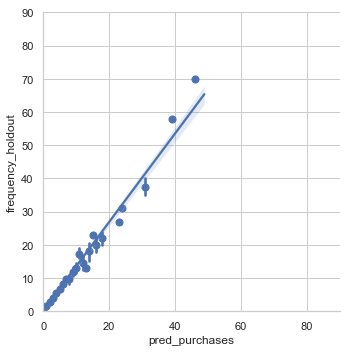

In [20]:
# Display the error (regression line should be 1 to 1)
sns.lmplot(x="pred_purchases", 
           y="frequency_holdout", 
           data=pred_evaluation, 
           x_estimator=np.mean,
           palette=['rebeccapurple', 'yellow']);

plt.xlim(0, 90)
plt.ylim(0, 90);

**Observation:** The correlation is very high, but the (linear) prediction constantly underestimates the effective purchases.

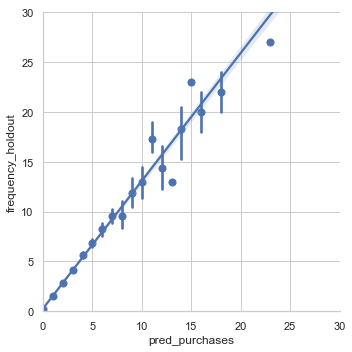

In [21]:
# Trim outliers
pred_evaluation_trimmed = pred_evaluation.loc[
        pred_evaluation['frequency_holdout'] <= 30]

sns.lmplot(x="pred_purchases", 
           y="frequency_holdout", 
           data=pred_evaluation_trimmed, 
           x_estimator=np.mean,
           palette=['rebeccapurple', 'yellow']);

plt.xlim(0, 30)
plt.ylim(0, 30);

**Observation:** Without the frequency outliers the fit is a little better, but the prediction is still to low.

## 3) Estimate customer lifetime value using the Gamma-Gamma model
To estimate the CLV we use the [Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). It can be seen as an extension to the BG/NBD model, which focuses on modeling purchase count. Gamma-Gamma makes a few assumptions:
* At the customer level, the transaction/order value varies randomly around each customer’s average transaction value. (That, in itself, isn’t too controversial, but has to be checked, see below.)
* The observed mean value is an imperfect metric of the latent mean transaction value E(M), where M represents the monetary value.
* Average transaction value varies across customers, though these values are stationary. (This is a big assumption to make.)
* The distribution of average values across customers is independent of the transaction process. In other words, monetary value can be modeled separately from the purchase count and lifetime components of the model. This may or may not hold in typical business situations.

**IMPORTANT:** Fit only to returning customers (but you can predict for all)

In [22]:
# Drop all one-time-only customers as clv can only be calculated for returning customers
returning_customers = clv.loc[clv['frequency'] > 0]
print(len(returning_customers))
display(returning_customers.head())

2790


,frequency,recency,T,monetary_value
CustomerID,,,,
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12352,6.0,260.0,296.0,368.256667
12356,2.0,303.0,325.0,269.905000
12358,1.0,149.0,150.0,683.200000


In [23]:
# Check for independence between Frequency and Monetary Value
print("Pearson's r: ", round(np.corrcoef(returning_customers['monetary_value'],
                                         returning_customers['frequency'])[0][1], 2))

Pearson's r:  0.02


In [24]:
# Fit Gamma-Gamma-Model on returning customers
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

# Check results
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>


In [25]:
# Predict CLV for a given period (in months) with bgf and ggf
clv_estimates = ggf.customer_lifetime_value(
    bgf,
    clv['frequency'],
    clv['recency'],
    clv['T'],
    clv['monetary_value'],
    time=4, # in months
    discount_rate=0.00)  # none for evaluation purposes

In [26]:
# Check results
display(clv_estimates.head())

CustomerID
12346      96.320445
12347    1069.324034
12348     355.312754
12349     453.557080
12350     100.175572
Name: clv, dtype: float64

### Estimate average transaction values

This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

In [27]:
avg_value = ggf.conditional_expected_average_profit(clv['frequency'],
                                                    clv['monetary_value'])

# check resutls
avg_value.head()

CustomerID
12346    416.945993
12347    569.978835
12348    333.784221
12349    416.945993
12350    416.945993
dtype: float64

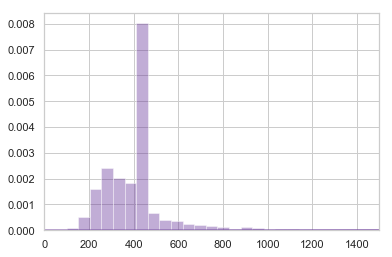

In [28]:
sns.distplot(avg_value, bins=1500, color='rebeccapurple')
plt.xlim(0,1500);

**Observation:** The distribution differs quite a bit from the original values - see EDA notebook.

In [29]:
# Compare mean of all avg_predictions vs effectively observed values
print("Expected conditional average value:", avg_value.mean()) # all customers
print("Observed average value:", returning_customers['monetary_value'].mean()) # returning only!

Expected conditional average value: 441.15942880744007
Observed average value: 477.3803385139518


**Observation:** You cannot directly compare to monetary_value in clv_data, because the value of the first purchase is not calculated. From EDA I know that the average value per customer is 458 - so at least that is pretty close.

---

# APPENDIX - 2nd run: Calculations after removing Outliers

**Summary:"" I tested if outlier removal would improve the predictions, but it made the results worse.

In [30]:
clean.count_outliers_IQR_method(clv, IQR_dist=2.5)

frequency
Identified outliers: 240
Percentage of outliers: 5.5%

recency
Identified outliers: 0
Percentage of outliers: 0.0%

T
Identified outliers: 0
Percentage of outliers: 0.0%

monetary_value
Identified outliers: 94
Percentage of outliers: 2.2%



In [31]:
clv_out = clean.remove_outliers_IQR_method(clv, IQR_dist=2.5)  # chose IQR-Dist of 2.5

frequency
Rows removed: 240

recency
Rows removed: 0

T
Rows removed: 0

monetary_value
Rows removed: 76


Rows removed in total: 316



In [32]:
# Get indices / ids of outlier customers
ids_out = set(clv.index).difference(clv_out.index)
assert len(ids_out) == len(clv) - len(clv_out)
# Make a new transaction set without outliers
clv_data_out = clv_data[~clv_data['CustomerID'].isin(ids_out)]

In [33]:
# Fit model with calibration and holdout sets on new data
summary_cal_holdout = calibration_and_holdout_data(clv_data_out, 'CustomerID', 'InvoiceDate', 
                                                   monetary_value_col='Sales',
                                                   calibration_period_end='2011-07-09',  # 7 months
                                                   observation_period_end='2011-12-09',  # 5 months
                                                   ) 

In [34]:
# Check results
print(summary_cal_holdout.shape)
display(summary_cal_holdout.head())

(2706, 7)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,172.0,0.000000,0.0,0.000000,<153 * Days>
12347,3.0,184.0,214.0,498.053333,3.0,26.300625,<153 * Days>
12348,2.0,110.0,205.0,297.220000,1.0,103.333333,<153 * Days>
12350,0.0,0.0,157.0,0.000000,0.0,0.000000,<153 * Days>
12352,3.0,34.0,143.0,421.770000,3.0,20.090000,<153 * Days>


In [35]:
# 'Repair' duration_holdout: set to float - should not happen according to docs ...
import re
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].astype(str)    
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].apply(lambda x: int(re.findall('\d+', x)[0]))

In [36]:
# Check results
display(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,172.0,0.000000,0.0,0.000000,153
12347,3.0,184.0,214.0,498.053333,3.0,26.300625,153
12348,2.0,110.0,205.0,297.220000,1.0,103.333333,153
12350,0.0,0.0,157.0,0.000000,0.0,0.000000,153
12352,3.0,34.0,143.0,421.770000,3.0,20.090000,153


In [37]:
# Fit on the _cal columns, and test on the _holdout columns"""
bgf_out = BetaGeoFitter(penalizer_coef=0.0)
bgf_out.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2706 subjects, a: 0.00, alpha: 239.04, b: 1.04, r: 1.82>

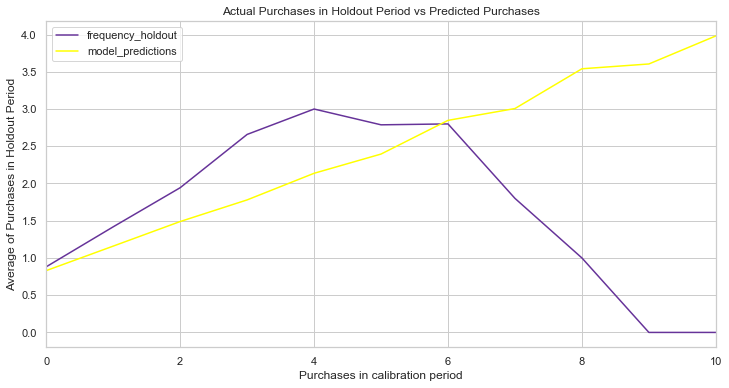

In [38]:
# Plot results
plot_calibration_purchases_vs_holdout_purchases(bgf_out, 
                                                summary_cal_holdout, 
                                                figsize=(12,6),
                                                n=int(summary_cal_holdout['frequency_cal'].max() + 1),
                                                color=['rebeccapurple', 'yellow']
                                                );

In [39]:
def predict_individual_purchases_float(model, df, t):
    """Predict number of purchases for period t for each customer
    and return them, rounded to int, in a DataFrame.
    """
    pred_list = []
    for customer in df.itertuples():
        pred_purchases = model.predict(t, 
                                     int(customer[1]), 
                                     int(customer[2]), 
                                     int(customer[3])
                                     )
        pred_list.append({'id': customer[0], 
                          'pred_purchases': pred_purchases})  # NOT round to int

    pred_df = pd.DataFrame(pred_list, columns=['id', 'pred_purchases'])
    pred_df.set_index('id', inplace=True)
    
    return pred_df

In [40]:
# Call function and check results
t = summary_cal_holdout.iloc[0,-1]  # set no of periods == duration_holdout
pred_purchases = predict_individual_purchases(bgf_out, clv_out, t)
display(pred_purchases.head())

,pred_purchases
id,
12346,0
12347,1
12348,1
12349,1
12350,0


In [41]:
# Compare predictions to effective frequencies in holdout set
pred_evaluation = pd.concat([pred_purchases, 
                            summary_cal_holdout[['frequency_holdout']]], 
                            axis=1, 
                            sort=True
                            )

# For eval only look at customers with frequency value in holdout
pred_evaluation.dropna(how = 'any', inplace=True)
assert len(pred_evaluation) == len(summary_cal_holdout)

print("Pearson's R: ", round(pred_evaluation.corr().iloc[0,1],3))

Pearson's R:  0.822


In [42]:
pred_evaluation['diff'] = np.abs(pred_evaluation['pred_purchases'] - pred_evaluation['frequency_holdout'])
print("Mean diff: ", pred_evaluation['diff'].sum() / len(pred_evaluation))

Mean diff:  0.7930524759793053


0.0    0.480414
1.0    0.333703
2.0    0.124908
3.0    0.040650
4.0    0.014782
5.0    0.004804
6.0    0.000739
Name: diff, dtype: float64

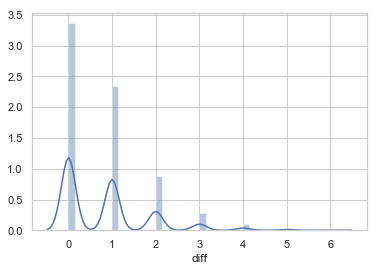

In [43]:
display(pred_evaluation['diff'].value_counts(dropna=False) / len(pred_evaluation))
sns.distplot(pred_evaluation['diff']);

### Estimate CLV

In [44]:
returning_out = clv_out.loc[clv_out['frequency'] > 0]
print(len(returning_out))
display(returning_out.head())

2474


,frequency,recency,T,monetary_value
CustomerID,,,,
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12352,6.0,260.0,296.0,368.256667
12356,2.0,303.0,325.0,269.905000
12358,1.0,149.0,150.0,683.200000


In [45]:
# Fit Gamma-Gamma-Model on returning customers
ggf_out = GammaGammaFitter(penalizer_coef = 0)
ggf_out.fit(returning_out['frequency'],
            returning_out['monetary_value'])

# Check results
print(ggf_out)

<lifetimes.GammaGammaFitter: fitted with 2474 subjects, p: 1.81, q: 7.00, v: 1153.21>


In [46]:
# Predict CLV for a given period (in months) with bgf and ggf
clv_estimates_out = ggf_out.customer_lifetime_value(
    bgf_out,
    clv['frequency'],
    clv['recency'],
    clv['T'],
    clv['monetary_value'],
    time=4, # in months
    discount_rate=0.00)  # none for evaluation purposes

In [47]:
avg_value_out = ggf_out.conditional_expected_average_profit(clv['frequency'],
                                                        clv['monetary_value'])

# Check results
avg_value_out.head()

CustomerID
12346    348.548248
12347    510.432684
12348    326.165418
12349    348.548248
12350    348.548248
dtype: float64

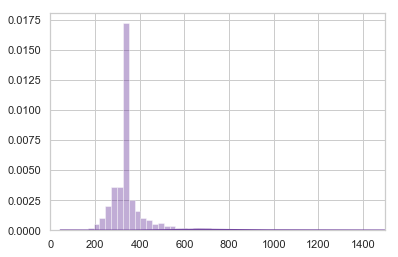

In [48]:
sns.distplot(avg_value_out, bins=1500, color='rebeccapurple')
plt.xlim(0,1500);

In [49]:
# Compare mean of all avg_predictions vs effectively observed values
print("Expected conditional average value:", avg_value_out.mean()) # all customers
print("Observed average value:", returning_out['monetary_value'].mean()) # returning only!

Expected conditional average value: 386.37134530167395
Observed average value: 335.16707528133816


---